# **Classifying Clothing Images**

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 24.8 GB  | Proc size: 232.1 MB
GPU RAM Free: 10438MB | Used: 737MB | Util   7% | Total 11175MB


In [3]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [4]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


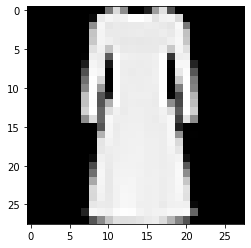

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [6]:
images[0].size()

torch.Size([1, 28, 28])

In [7]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.out_channel = 6
        self.conv = nn.Sequential(
                        nn.Conv2d(1, self.out_channel, 5),
                        nn.ReLU(),
                        nn.BatchNorm2d(self.out_channel),
                        nn.Dropout(0.2),
                        nn.Conv2d(self.out_channel, self.out_channel, 5),
                        nn.ReLU(),
                        nn.BatchNorm2d(self.out_channel),
                        nn.Dropout(0.2),
                    )

        self.conv_out_dim = 20
        self.out_dim = 1024
        self.seq = nn.Sequential(
                        nn.Linear(self.out_channel * self.conv_out_dim * self.conv_out_dim, self.out_dim),
                        nn.ReLU(),
                    )
        
        self.residual_downsampler = nn.Sequential(
                                nn.Linear(1 * 28 * 28, self.out_dim),
                                nn.ReLU(),
                            )
            
        self.fc = nn.Sequential(
                        nn.Linear(self.out_dim, 10),
                        nn.LogSoftmax(dim=1),
                    )
    
    def forward(self, x):
        x_ = self.conv(x)
        x_ = x_.view(-1, self.out_channel * self.conv_out_dim * self.conv_out_dim)
        x_ = self.seq(x_)

        res = x.view(-1, 28 * 28)
        res = self.residual_downsampler(res)
        x = x_ + res
                
        x = self.fc(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Define the loss
criterion = nn.NLLLoss().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

# Define the epochs
epochs = 15

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0

    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()

        # Validation pass
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        test_loss = test_loss.to('cpu')
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15.. Training loss: 0.427.. Test loss: 0.365.. Test Accuracy: 0.864
Epoch: 2/15.. Training loss: 0.294.. Test loss: 0.320.. Test Accuracy: 0.878
Epoch: 3/15.. Training loss: 0.239.. Test loss: 0.310.. Test Accuracy: 0.888
Epoch: 4/15.. Training loss: 0.197.. Test loss: 0.296.. Test Accuracy: 0.897
Epoch: 5/15.. Training loss: 0.164.. Test loss: 0.313.. Test Accuracy: 0.896
Epoch: 6/15.. Training loss: 0.134.. Test loss: 0.322.. Test Accuracy: 0.902
Epoch: 7/15.. Training loss: 0.114.. Test loss: 0.323.. Test Accuracy: 0.907
Epoch: 8/15.. Training loss: 0.096.. Test loss: 0.316.. Test Accuracy: 0.904
Epoch: 9/15.. Training loss: 0.080.. Test loss: 0.370.. Test Accuracy: 0.904
Epoch: 10/15.. Training loss: 0.074.. Test loss: 0.398.. Test Accuracy: 0.902
Epoch: 11/15.. Training loss: 0.061.. Test loss: 0.414.. Test Accuracy: 0.898
Epoch: 12/15.. Training loss: 0.056.. Test loss: 0.448.. Test Accuracy: 0.899
Epoch: 13/15.. Training loss: 0.053.. Test loss: 0.443.. Test Accuracy: 0

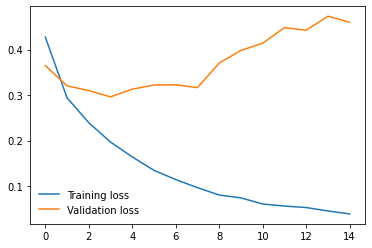

In [8]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

**Saving the model**

In [9]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Net(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
  )
  (seq): Sequential(
    (0): Linear(in_features=2400, out_features=1024, bias=True)
    (1): ReLU()
  )
  (residual_downsampler): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
) 

The state dict keys: 

 odict_keys(['conv.0.weight', 'conv.0.bias', 'conv.2.weight', 'conv.2.bias', 'conv.2.running_mean', 'conv.2.running_var', 'conv.2.num_batches_tracked', 'conv.4.weight', 'conv.4.bias', 'conv.

In [10]:
DIR = "checkpoints"

if not os.path.isdir(DIR):
    os.mkdir(DIR)

    
torch.save(model.state_dict(), DIR + '/fashion_mnist_checkpoint.pth')